# Quebec equivalence graph

In [ ]:
from collections import defaultdict
from itertools import product
import json
import os
import sys

from carbonplan_styles.mpl import set_theme
from carbonplan_styles.colors import colors
from fair.SSPs import ssp245
import fair_equivalence_graphs as temp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tonyear

In [ ]:
save_data = False

In [ ]:
sns.set(font_scale=1.5)
sns.set_style("white")

set_theme(style="carbonplan_light")
c = colors("carbonplan_light")

In [ ]:
joos_baseline = tonyear.get_baseline_curve("joos_2013")
time_horizon = 100
discount_rate = 0
delays = [1, 10, 20, 50, 80, 100]
methods = ["qc", "lashof", "mc"]

Justified emissions: 1 GtCO2


Text(0, 0.5, 'Temperature difference (K)')

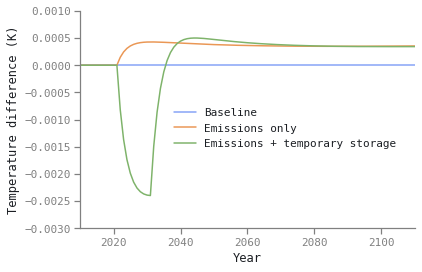

In [ ]:
scenario = ssp245
delay_yr = 2022
time_horizon = 100

delay = 10  # years
equivalence_ratio = d[delay]["qc"]
delay_magnitude = equivalence_ratio * (12 / 44)  # tonyear produces co2, FaIR wants C


print(
    f"Justified emissions: {round((delay_magnitude / equivalence_ratio)*(44/12))} GtCO2"
)

storage, reemission, justified = temp.get_perturbations(
    scenario, delay_yr, delay, delay_magnitude, equivalence_ratio
)
_, fair_results = temp.run_fair(scenario, storage, reemission, justified)

t_diff = {
    "offset": np.array(fair_results["offset"]["temp"])
    - np.array(fair_results["default"]["temp"]),
    "baseline": np.array(fair_results["default"]["temp"])
    - np.array(fair_results["default"]["temp"]),
    "emission": np.array(fair_results["justified"]["temp"])
    - np.array(fair_results["default"]["temp"]),
}

years = scenario.Emissions.year
plt.plot(years, t_diff["baseline"], label="Baseline")
plt.plot(years, t_diff["emission"], label="Emissions only")
plt.plot(years, t_diff["offset"], label=f"Emissions + temporary storage")

plt.xlim(2010, 2110)
plt.ylim(-0.003, 0.001)

plt.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.25, 0.6))
plt.xlabel("Year")
plt.ylabel("Temperature difference (K)")

## Package for front-end

In [ ]:
def sample_t_diff_curve(t_diff: np.array, years: np.array, freq=5) -> np.array:
    """Sample from temperature difference curves to repackage for frontend display"""
    data = np.vstack([years, t_diff]).T[::freq]
    return data


def clip_sampled_curve(sampled_curve: np.array, from_year=2000, to_year=2120):
    """subsample again to specific time domain we're interested in"""
    from__idx = np.where(sampled_curve[:, 0] == from_year)[0][0]
    to_idx = row_idx = np.where(sampled_curve[:, 0] == to_year)[0][0] + 1
    return sampled_curve[from__idx:to_idx]


def clipped_to_frontend_arr(clipped_curve: np.array) -> dict:
    """"""
    return [{"y": row[0], "x": round(row[1], 6)} for row in clipped_curve]


def reformat_for_frontend(arr, years):
    """stringing together the underlying three steps"""
    sampled = sample_t_diff_curve(arr, years)
    clipped = clip_sampled_curve(sampled)
    fe_arr = clipped_to_frontend_arr(clipped)
    return fe_arr

In [ ]:
if save_data:
    print("saving data to /tmp")
    json.dump(
        {k: reformat_for_frontend(v, years) for k, v in t_diff.items()},
        open("/tmp/equivalence-chart-data.json", "w"),
    )